In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import norm
from requests_oauthlib import OAuth2Session
import vk
import time
import re
from tqdm import tqdm
from retry import retry
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

import secret

In [2]:
FEMALE = 1 
MALE = 2
UNKNOWN = 0

## Выгрузка данных с сайта

In [ ]:
def get_token(client_id, client_secret, redirect_url, vk_url, vk_token):
    oauth = OAuth2Session(client_id, redirect_uri=redirect_url)
    authorization_url, state = oauth.authorization_url(vk_url)
    print('Please go to %s and authorize access.' % authorization_url)
    authorization_response = input('Enter the full callback URL')
    token = oauth.fetch_token(
        vk_token,
        authorization_response=authorization_response,
        client_secret=client_secret)
    return oauth, token

In [ ]:
client_id = secret.client_id
client_secret = secret.client_secret
vk_url = secret.vk_url
vk_token=secret.vk_token
display = secret.display
redirect_url = secret.redirect_url
loca_version = False

In [ ]:
_, token = get_token(client_id,client_secret,redirect_url,vk_url,vk_token)

In [ ]:
session = vk.Session(access_token=token['access_token'])

In [ ]:
api = vk.API(session, timeout=3600)

In [ ]:
users_size = api.groups.getMembers(group_id='openairs1')['count']
users_dump = set()
for i in range(users_size / 1000 + 1):
    users_dump = users_dump.union(api.groups.getMembers(group_id='openairs1', offset = i * 1000)['users'])
    time.sleep(0.4)
users = {
    'count' : users_size,
    'users' : list(users_dump)
}

In [ ]:
with open('data/user_metadata.json', 'w') as fp:
        json.dump(users, fp)

In [ ]:
assert(users['count'] == len(users['users']))

In [ ]:
@retry(delay=1, backoff=2, tries=8)
def get_user_info(api, user):
    return api.users.get(user_ids = user, fields = u'photo_id, verified, sex, bdate, city, country, home_town, has_photo, photo_50, photo_100, photo_200_orig, photo_200, photo_400_orig, photo_max, photo_max_orig, online, lists, domain, has_mobile, contacts, site, education, universities, schools, status, last_seen, followers_count, common_count, occupation, nickname, relatives, relation, personal, connections, exports, wall_comments, activities, interests, music, movies, tv, books, games, about, quotes, can_post, can_see_all_posts, can_see_audio, can_write_private_message, can_send_friend_request, is_favorite, is_hidden_from_feed, timezone, screen_name, maiden_name, crop_photo, is_friend, friend_status, career, military, blacklisted, blacklisted_by_me')

In [ ]:
pages = int(users['count']) / 1000

In [ ]:
starts = [i * 1000 for i in range(pages + 1) ]
ends = [(i + 1) * 1000 for i in range(pages + 1)]
intervals = zip(starts, ends)

In [ ]:
user_list = list()
for entry in tqdm(intervals):
    start, end = entry
    users_inf = get_user_info(api, users['users'][start:end])
    user_list.extend(users_inf)

In [ ]:
assert(users['count'] == len(user_list))

In [ ]:
for usr in tqdm(user_list):
    fn = 'data/%s.json' % usr['uid']
    with open(fn, 'w') as fl:
        json.dump(usr, fl)

## Загрузка с диска

In [3]:
with open('data/user_metadata.json', 'r') as fp:
        users = json.load(fp)

In [4]:
user_list = list()
for usr in tqdm(users['users']):
    fn = 'data/%s.json' % usr
    with open(fn, 'r') as fl:
        user_list.append(json.load(fl))

100%|██████████████████████████████████| 19668/19668 [00:16<00:00, 1209.89it/s]


In [5]:
columns = [u'uid', u'bdate', u'sex', u'books', u'movies', u'games', u'music', u'activities']

In [6]:
df = pd.DataFrame(columns=columns)

In [7]:
for usr in tqdm(user_list):
    df.loc[df.size] = [usr.get(name, np.nan) for name in columns]

100%|███████████████████████████████████| 19668/19668 [02:03<00:00, 159.54it/s]


In [8]:
df[['uid', 'sex']] = df[['uid', 'sex']].astype(int)

In [9]:
df.head()

,uid,bdate,sex,books,movies,games,music,activities
0,1245186,31.1.1979,2,NaN,NaN,NaN,NaN,NaN
8,210370563,NaN,1,NaN,NaN,NaN,NaN,NaN
16,93061126,NaN,1,NaN,NaN,NaN,NaN,NaN
24,19202055,NaN,1,NaN,NaN,NaN,NaN,NaN
32,81068043,NaN,2,,,,"Music, Guitar, Piano",


## Анализ

In [10]:
nothing = len(df[df['sex'] == UNKNOWN])
female = len(df[df['sex'] == FEMALE])
male = len(df[df['sex'] == MALE])

In [11]:
X = np.array(list("MFN"))
y = np.array([male,female, nothing])

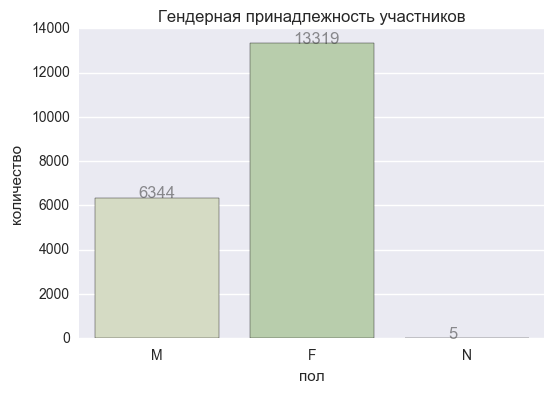

In [12]:
g = sns.barplot(y=y,x=X,alpha=1,palette=sns.cubehelix_palette(10, start=.5, rot=-.75))
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + .28, height, '%1d'%(height), fontdict=dict(size = 12,alpha=0.5))
g.set(xlabel = u'пол', ylabel=u'количество')
sns.plt.title(u'Гендерная принадлежность участников');

In [13]:
df.fillna(value=np.nan, inplace=True)

In [14]:
df = df.replace(r'(^\s+$|^$)',np.nan,regex=True)

In [15]:
print u'Музыка: %s' % df[~df.music.isnull()].size
print u'Книги: %s' % df[~df.books.isnull()].size
print u'Фильмы: %s' % df[~df.movies.isnull()].size
print u'Игры: %s' % df[~df.games.isnull()].size
print u'Активность: %s' % df[~df.activities.isnull()].size

Музыка: 15176
Книги: 14752
Фильмы: 15304
Игры: 10608
Активность: 14536


In [16]:
df_music_none_null = df[~df.music.isnull()]
df_books_none_null = df[~df.books.isnull()]
df_movies_none_null = df[~df.movies.isnull()]
df_games_none_null = df[~df.games.isnull()]
df_activities_none_null = df[~df.activities.isnull()]

In [17]:
not_empty = lambda x : not re.search('(^\s+$|^$)', x)
trim_stair = lambda x : re.sub(r'^\s+', '', x)
delete_numbers = lambda x: not re.search(r'^(\s+|)\d$',x)
remove_quotas = lambda x : re.sub(r'"', '', x)
to_upper_case = lambda x : x.title()

In [18]:
df_music_none_null.loc[:,'music'] = (
    df_music_none_null['music']
    .map(lambda x: x.split(','))
    .map(lambda x: filter(not_empty, x))
    .map(lambda x: map(trim_stair, x))
    .map(lambda x: filter(delete_numbers, x))
    .map(lambda x: map(remove_quotas, x))
    .map(lambda x: map(to_upper_case, x))
)
df_books_none_null.loc[:,'books'] = (
    df_books_none_null['books']
    .map(lambda x: x.split(','))
    .map(lambda x: filter(not_empty, x))
    .map(lambda x: map(trim_stair, x))
    .map(lambda x: filter(delete_numbers, x))
    .map(lambda x: map(remove_quotas, x))
    .map(lambda x: map(to_upper_case, x))
)
df_movies_none_null.loc[:,'movies'] = (
    df_movies_none_null['movies']
    .map(lambda x: x.split(','))
    .map(lambda x: filter(not_empty, x))
    .map(lambda x: map(trim_stair, x))
    .map(lambda x: filter(delete_numbers, x))
    .map(lambda x: map(remove_quotas, x))
    .map(lambda x: map(to_upper_case, x))
)
df_games_none_null.loc[:,'games'] = (
    df_games_none_null['games']
    .map(lambda x: x.split(','))
    .map(lambda x: filter(not_empty, x))
    .map(lambda x: map(trim_stair, x))
    .map(lambda x: filter(delete_numbers, x))
    .map(lambda x: map(remove_quotas, x))
    .map(lambda x: map(to_upper_case, x))
)

df_activities_none_null.loc[:,'activities'] = (
    df_activities_none_null['activities']
    .map(lambda x: x.split(','))
    .map(lambda x: filter(not_empty, x))
    .map(lambda x: map(trim_stair, x))
    .map(lambda x: filter(delete_numbers, x))
    .map(lambda x: map(remove_quotas, x))
    .map(lambda x: map(to_upper_case, x))
)

C:\Users\MrFroll\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
def count(items, column, title = ''):
    cnt = Counter()
    for item in items:
        cnt.update(item)
    df = pd.DataFrame(cnt.most_common(10), columns=[column, 'number'])
    g = sns.barplot(y=column,x='number',data=df, alpha=1,palette=sns.cubehelix_palette(10, start=.5, rot=-.75))
    g.set(xlabel = u'количество')
    sns.plt.title(title)

In [20]:
def parts(df_full, df_parted):
    return [len(df_parted) * 1. / len(df_full) * 100, (len(df_full) - len(df_parted)) * 1. / len(df_full) * 100]

In [21]:
def responded(df_full, df_interested, local_title = ''):
    explode = (0.1, 0)
    colors = sns.cubehelix_palette(10, start=.5, rot=-.75)
    plt.pie(parts(df_full, df_interested), explode=explode, labels=[u'ответившие', u'не ответившие'], colors=[colors[len(colors) // 8], colors[len(colors) // 2]],
        autopct='%1.1f%%', startangle=140);
    plt.axis('equal');
    plt.title(local_title);

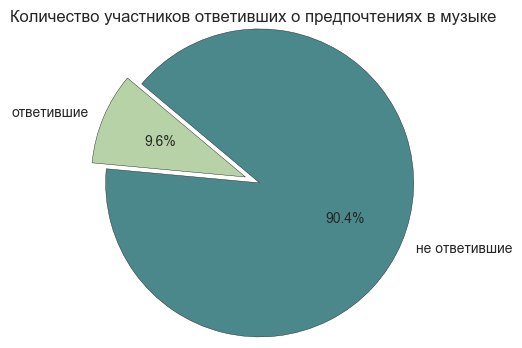

In [22]:
responded(df, df_music_none_null, u'Количество участников ответивших о предпочтениях в музыке')

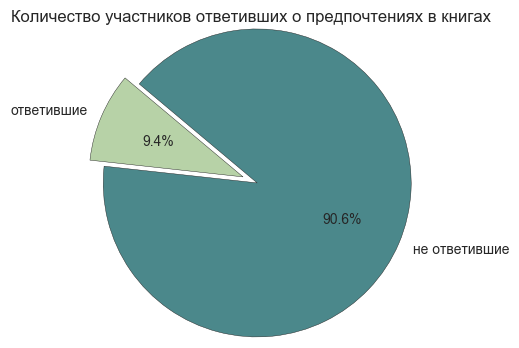

In [23]:
responded(df, df_books_none_null, u'Количество участников ответивших о предпочтениях в книгах')

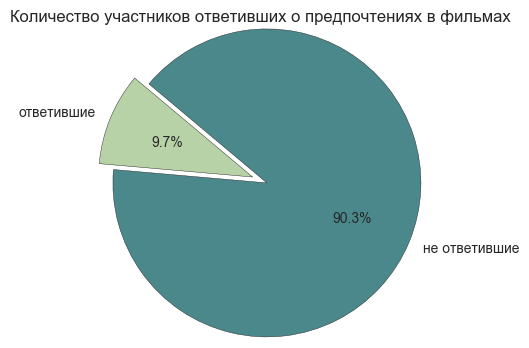

In [24]:
responded(df, df_movies_none_null, u'Количество участников ответивших о предпочтениях в фильмах')

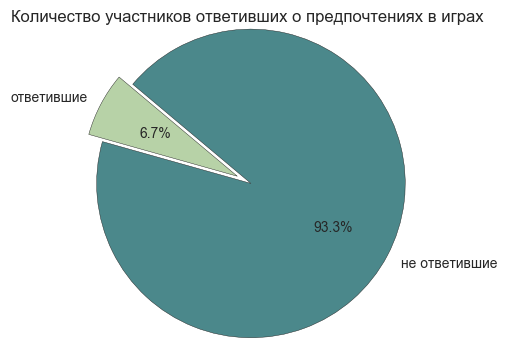

In [25]:
responded(df, df_games_none_null, u'Количество участников ответивших о предпочтениях в играх')

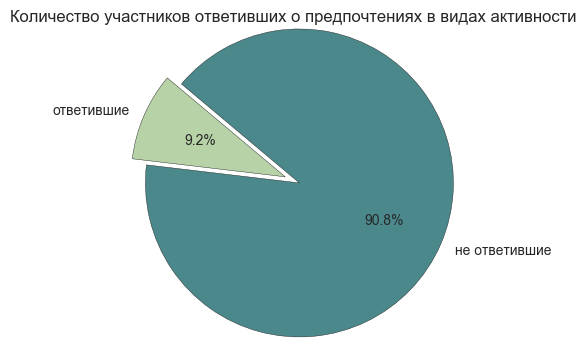

In [26]:
responded(df, df_activities_none_null, u'Количество участников ответивших о предпочтениях в видах активности')

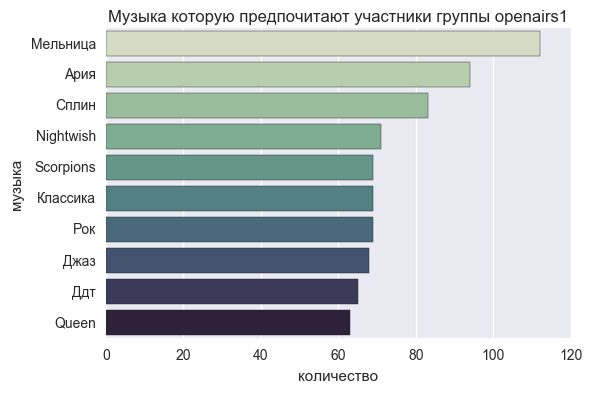

In [27]:
count(df_music_none_null.music, u'музыка', title=u'Музыка которую предпочитают участники группы openairs1')

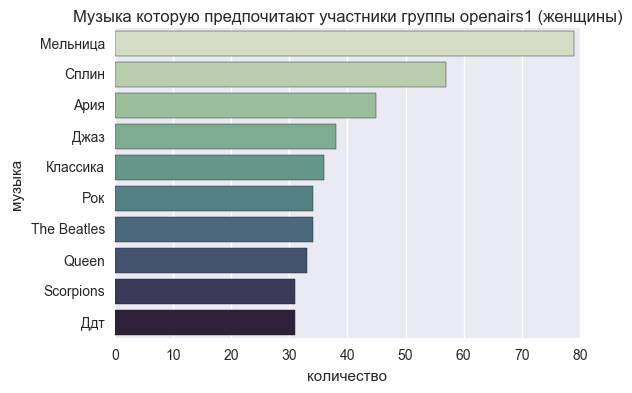

In [28]:
music_female = df_music_none_null[df_music_none_null.sex == FEMALE].music
count(music_female, u'музыка', title=u'Музыка которую предпочитают участники группы openairs1 (женщины)')

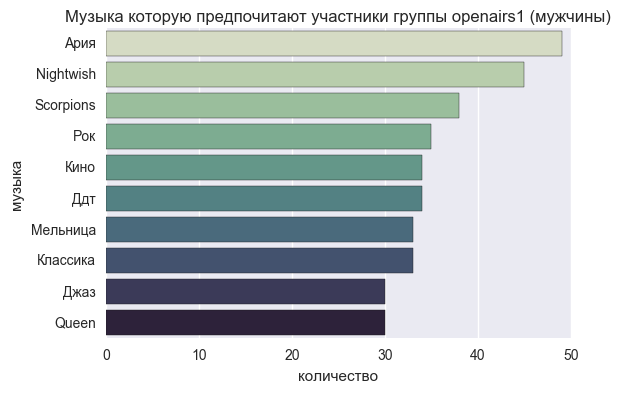

In [29]:
music_male = df_music_none_null[df_music_none_null.sex == MALE].music
count(music_male, u'музыка', title=u'Музыка которую предпочитают участники группы openairs1 (мужчины)')

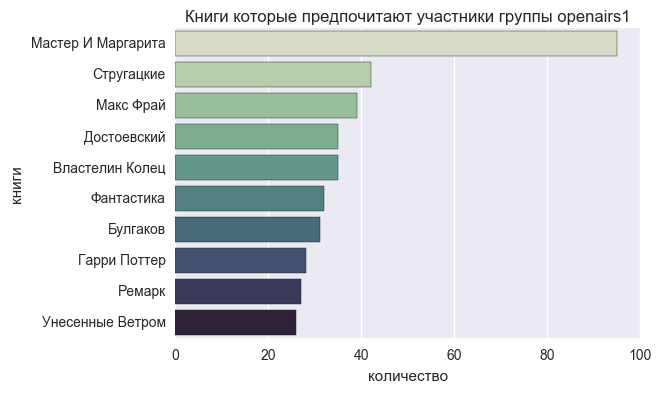

In [30]:
count(df_books_none_null.books, u'книги',  title=u'Книги которые предпочитают участники группы openairs1')

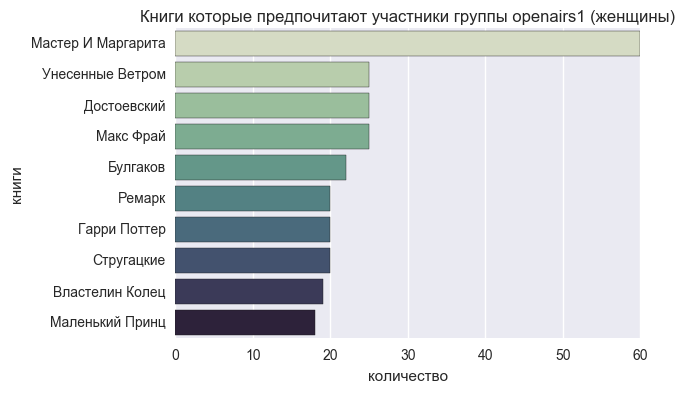

In [31]:
books_female = df_books_none_null[df_books_none_null.sex == FEMALE].books
count(books_female, u'книги', title=u'Книги которые предпочитают участники группы openairs1 (женщины)')

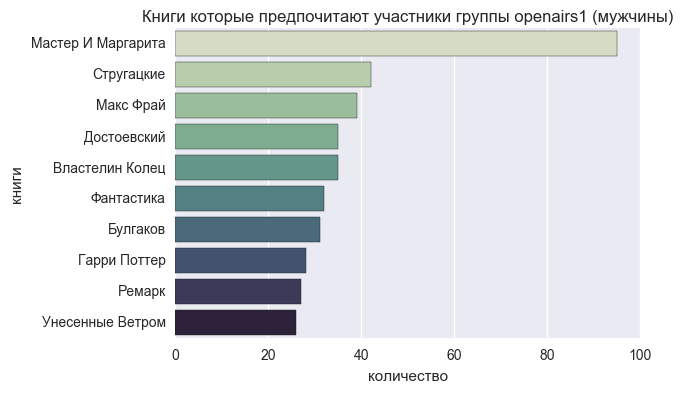

In [32]:
if np.any(df_books_none_null.books.str.contains("^^^^^|__",regex=False)):
    books_male = df_books_none_null.drop(index)[df_books_none_null.sex == MALE].books
else:
    books_male = df_books_none_null.books
count(books_male, u'книги', title=u'Книги которые предпочитают участники группы openairs1 (мужчины)')

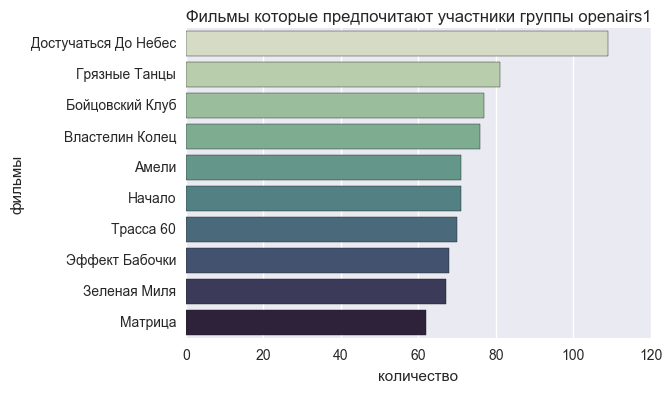

In [33]:
count(df_movies_none_null.movies, u'фильмы', title=u'Фильмы которые предпочитают участники группы openairs1')

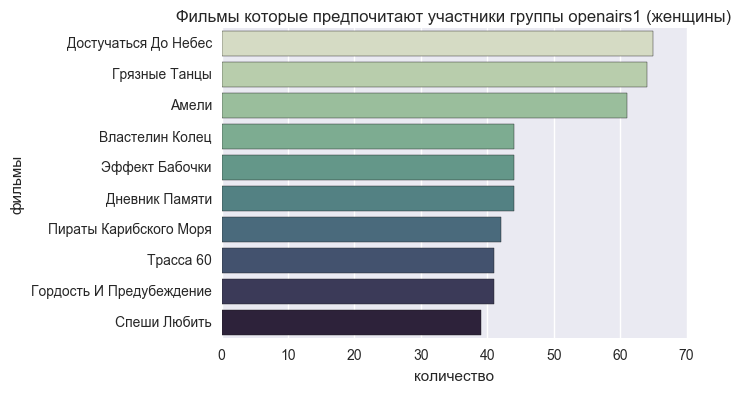

In [34]:
movies_female = df_movies_none_null[df_movies_none_null.sex == FEMALE].movies
count(movies_female, u'фильмы', title=u'Фильмы которые предпочитают участники группы openairs1 (женщины)')

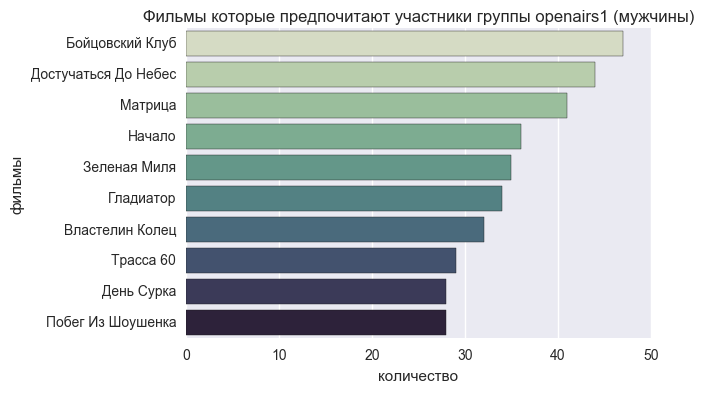

In [35]:
movies_male = df_movies_none_null[df_movies_none_null.sex == MALE].movies
count(movies_male, u'фильмы', title=u'Фильмы которые предпочитают участники группы openairs1 (мужчины)')

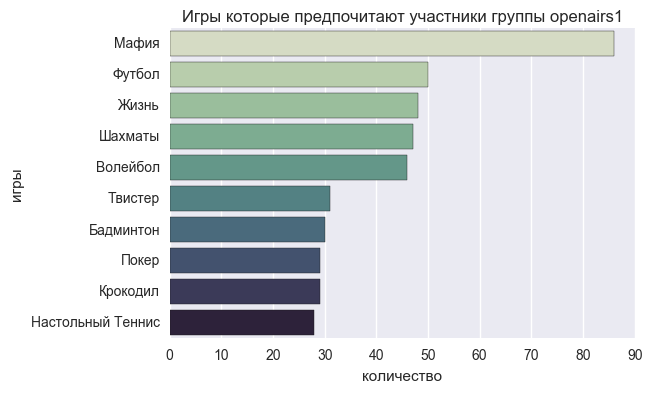

In [36]:
count(df_games_none_null.games, u'игры',  title=u'Игры которые предпочитают участники группы openairs1')

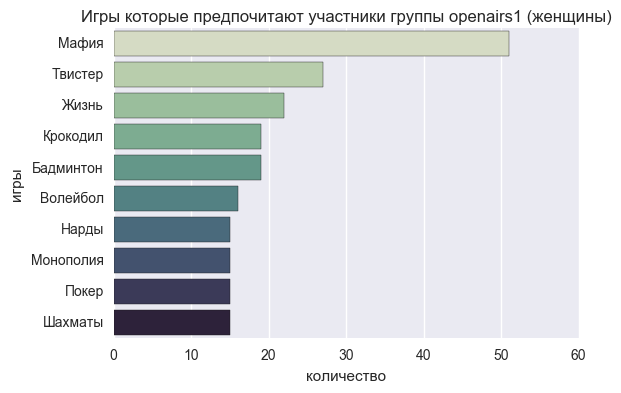

In [37]:
games_female = df_games_none_null[df_games_none_null.sex == FEMALE].games
count(games_female, u'игры', title=u'Игры которые предпочитают участники группы openairs1 (женщины)')

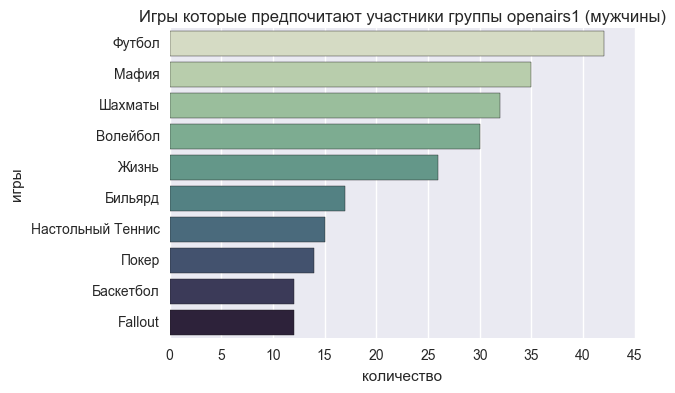

In [38]:
games_male = df_games_none_null[df_games_none_null.sex == MALE].games
count(games_male, u'игры', title=u'Игры которые предпочитают участники группы openairs1 (мужчины)')

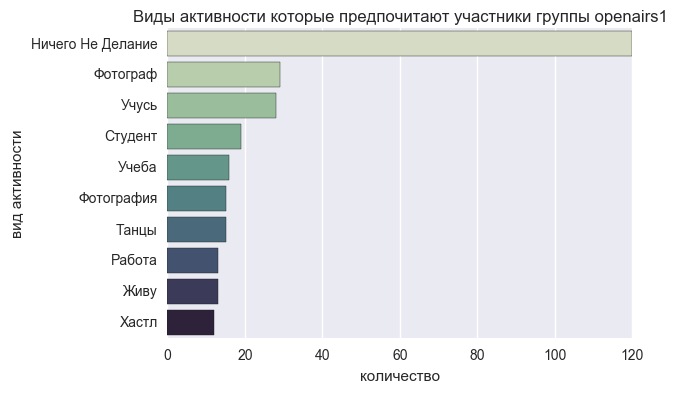

In [39]:
count(df_activities_none_null.activities, u'вид активности',  title=u'Виды активности которые предпочитают участники группы openairs1')

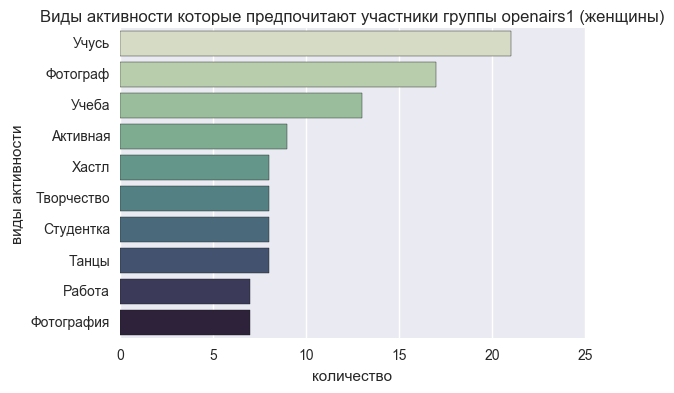

In [40]:
activities_male = df_activities_none_null[df_activities_none_null.sex == FEMALE].activities
count(activities_male, u'виды активности',  title=u'Виды активности которые предпочитают участники группы openairs1 (женщины)')

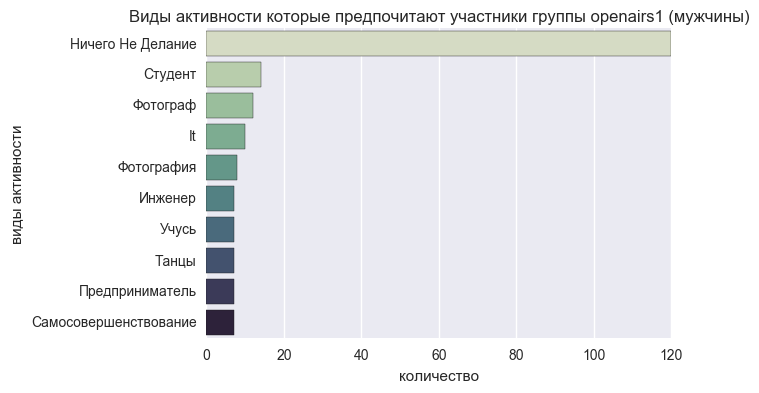

In [41]:
activities_male = df_activities_none_null[df_activities_none_null.sex == MALE].activities
count(activities_male, u'виды активности',  title=u'Виды активности которые предпочитают участники группы openairs1 (мужчины)')

## Возраст участников группы

In [42]:
df['bdate_date'] = df.bdate.map(lambda x: pd.to_datetime(x,errors = 'coerce'))
now = pd.datetime.now()
df['age'] = df.bdate_date.map(lambda x: ((now - x).days/365) if pd.notnull(x) else np.NaN)

In [43]:
df.sex.value_counts()

1    13319
2     6344
0        5
Name: sex, dtype: int64

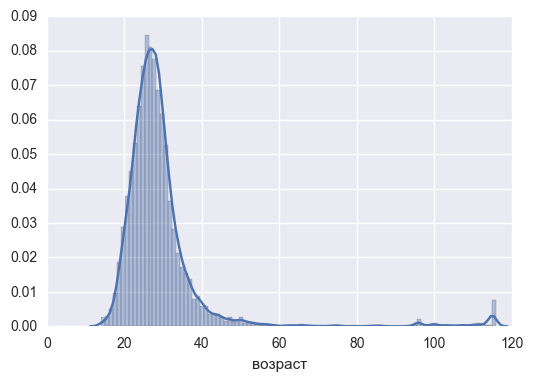

In [44]:
ax = sns.distplot(df.age.dropna().values,axlabel=u'возраст',label=u'частота',bins=100);

In [45]:
df.age.dropna().describe()

count    6411.000000
mean       29.385431
std        12.255004
min        14.000000
25%        24.000000
50%        27.000000
75%        31.000000
max       116.000000
Name: age, dtype: float64